In [8]:
import os
import sys
import re
from matplotlib import pyplot as plt
from coffea.util import load
from omegaconf import OmegaConf
import numpy as np
import awkward as ak
from pocket_coffea.utils.plot_utils import PlotManager
import argparse
import mplhep as hep

hep.style.use("CMS")

In [9]:
var_dict = {
    r"MET $p_{\mathrm{T}}$ [GeV]": [
        "PuppiMET_pt",
        "PuppiMETPNet_pt",
        "PuppiMETPNetPlusNeutrino_pt",
    ],
    r"MET $\phi$": ["PuppiMET_phi", "PuppiMETPNet_phi", "PuppiMETPNetPlusNeutrino_phi"],
    r"MET_MinusMuons $p_{\mathrm{T}}$ [GeV]": [
        "PuppiMET_MuonGood_pt",
        "PuppiMETPNet_MuonGood_pt",
        "PuppiMETPNetPlusNeutrino_MuonGood_pt",
    ],
    r"MET_MinusMuons $\phi$": [
        "PuppiMET_MuonGood_phi",
        "PuppiMETPNet_MuonGood_phi",
        "PuppiMETPNetPlusNeutrino_MuonGood_phi",
    ],
    r"$-u_{||}/q_{T}$": [
        "PuppiMET_MuonGood_response",
        "PuppiMETPNet_MuonGood_response",
        "PuppiMETPNetPlusNeutrino_MuonGood_response",
    ],
    r"$u_{||}+q_{T}$ [GeV]": [
        "PuppiMET_MuonGood_u_paral_predict",
        "PuppiMETPNet_MuonGood_u_paral_predict",
        "PuppiMETPNetPlusNeutrino_MuonGood_u_paral_predict",
    ],
    r"$u_{\perp}$ [GeV]": [
        "PuppiMET_MuonGood_u_perp_predict",
        "PuppiMETPNet_MuonGood_u_perp_predict",
        "PuppiMETPNetPlusNeutrino_MuonGood_u_perp_predict",
    ],
    r"MET $p_{\mathrm{T}}$ [GeV]": ["PuppiMET_pt", "PuppiMET_MuonGood_pt"],
    r"METPNet $p_{\mathrm{T}}$ [GeV]": ["PuppiMETPNet_pt", "PuppiMETPNet_MuonGood_pt"],
    r"METPNetPlusNeutrino $p_{\mathrm{T}}$ [GeV]": [
        "PuppiMETPNetPlusNeutrino_pt",
        "PuppiMETPNetPlusNeutrino_MuonGood_pt",
    ],
}
ranges = {
    r"MET $p_{\mathrm{T}}$ [GeV]": (0, 200),
    r"MET $\phi$": (-3.14, 3.14),
    r"MET_MinusMuons $p_{\mathrm{T}}$ [GeV]": (0, 200),
    r"MET_MinusMuons $\phi$": (-3.14, 3.14),
    r"$-u_{||}/q_{T}$": (-1, 2),
    r"$u_{||}+q_{T}$ [GeV]": (-200, 200),
    r"$u_{\perp}$ [GeV]": (-200, 200),
    r"MET $p_{\mathrm{T}}$ [GeV]": (0, 200),
    r"METPNet $p_{\mathrm{T}}$ [GeV]": (0, 200),
    r"METPNetPlusNeutrino $p_{\mathrm{T}}$ [GeV]": (0, 200),
}
log_dict = {
    r"MET $p_{\mathrm{T}}$ [GeV]": True,
    r"MET $\phi$": False,
    r"MET_MinusMuons $p_{\mathrm{T}}$ [GeV]": True,
    r"MET_MinusMuons $\phi$": False,
    r"$-u_{||}/q_{T}$": True,
    r"$u_{||}+q_{T}$ [GeV]": True,
    r"$u_{\perp}$ [GeV]": True,
    r"MET $p_{\mathrm{T}}$ [GeV]": True,
    r"METPNet $p_{\mathrm{T}}$ [GeV]": True,
    r"METPNetPlusNeutrino $p_{\mathrm{T}}$ [GeV]": True,
}
color_list = [
    "black",
    "red",
    "green",
    "orange",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

In [10]:
# input_dir = "/work/mmalucch/out_jme/MET_studies/"
input_dir = "/work/mmalucch/out_jme/DY_MET_NoStandardJEC/"
cfg = os.path.join(input_dir, "parameters_dump.yaml")
inputfile = os.path.join(input_dir, "output_all.coffea")
outputdir = os.path.join(input_dir, "plots_comparison")

# Load yaml file with OmegaConf
if cfg[-5:] == ".yaml":
    parameters_dump = OmegaConf.load(cfg)
else:
    raise Exception(
        "The input file format is not valid. The config file should be a in .yaml format."
    )

parameters = parameters_dump

# Resolving the OmegaConf
try:
    OmegaConf.resolve(parameters)
except Exception as e:
    print(
        "Error during resolution of OmegaConf parameters magic, please check your parameters files."
    )
    raise (e)

if os.path.isfile(inputfile):
    accumulator = load(inputfile)
else:
    sys.exit(f"Input file '{inputfile}' does not exist")

if not os.path.exists(outputdir):
    os.makedirs(outputdir)

sample = list(accumulator["columns"].keys())[0]
dataset = list(accumulator["columns"][sample].keys())[0]
category = list(accumulator["columns"][sample][dataset].keys())[0]

In [15]:
def plot_from_columns(accumulator):
    col_var = accumulator["columns"][sample][dataset][category]

    for vars_name, var_list in var_dict.items():

        fig, (ax, ax_ratio) = plt.subplots(
            2,
            1,
            figsize=[13, 13],
            sharex=True,
            gridspec_kw={"height_ratios": [2.5, 1]},
        )
        for i, variable in enumerate(var_list):
            col_num = col_var[variable].value
            if "phi" in variable:
                print(variable,  col_num)
            col_den = col_var[var_list[0]].value
            var_name = (
                variable.split("_")[0]
                if "MuonGood" not in variable
                else f'{variable.split("_")[0]}_MinusMuons'
            )

            # range_4b = (np.min(col_den), np.max(col_den))
            range_4b = ranges[vars_name]
            mask_range4b = (col_den > range_4b[0]) & (col_den < range_4b[1])
            col_num = col_num[mask_range4b]
            col_den = col_den[mask_range4b]

            h_den, bins = np.histogram(col_den, bins=30, range=range_4b)

            bins_center = (bins[1:] + bins[:-1]) / 2
            # draw the ratio
            h_num, bins = np.histogram(col_num, bins=30, range=range_4b)

            ratio = h_num / h_den
            err_num = np.sqrt(h_num)
            err_den = np.sqrt(h_den)
            ratio_err = np.sqrt(
                (err_num / h_den) ** 2 + (h_num * err_den / h_den**2) ** 2
            )

            if i == 0:
                ax.errorbar(
                    bins_center,
                    h_den,
                    yerr=np.sqrt(h_den),
                    label=var_name,
                    color=color_list[i],
                    fmt=".",
                )
                ax_ratio.axhline(y=1, linestyle="--", color="black")
                ax_ratio.fill_between(
                    bins_center,
                    1 - ratio_err,
                    1 + ratio_err,
                    color="grey",
                    alpha=0.5,
                )
            else:
                ax.hist(
                    col_num,
                    bins=30,
                    histtype="step",
                    label=var_name,
                    color=color_list[i],
                    range=range_4b,
                )
                ax_ratio.errorbar(
                    bins_center,
                    ratio,
                    yerr=ratio_err,
                    fmt=".",
                    label=var_name,
                    color=color_list[i],
                )

            del col_den, col_num

        ax.legend(loc="upper right")
        ax.set_yscale("log" if log_dict[vars_name] else "linear")
        hep.cms.lumitext(r"(13.6 TeV)", ax=ax)
        hep.cms.text(text="Simulation Preliminary", ax=ax)

        ax_ratio.set_xlabel(vars_name)
        ax.set_ylabel("Events")
        ax_ratio.set_ylabel("Reg./Std.")

        ax.grid()
        ax_ratio.grid()
        ax_ratio.set_ylim(0.5, 1.5)
        ax.set_ylim(
            top=(
                1.3 * ax.get_ylim()[1]
                if not log_dict[vars_name]
                else ax.get_ylim()[1] ** (1.3)
            )
        )

        fig.savefig(
            os.path.join(outputdir, f"{variable}.png"),
            bbox_inches="tight",
            dpi=300,
        )
        # plt.close(fig)
        fig.show()

/tmp/ipykernel_1895/443256620.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


PuppiMET_phi [-0.00992584  0.59436035  1.6948242  ...  2.4873047  -2.7954102
 -2.4980469 ]
PuppiMETPNet_phi [ 0.58469814  0.68855023  1.587329   ...  2.4652922  -2.9046698
 -2.5697732 ]
PuppiMETPNetPlusNeutrino_phi [ 0.5651696  0.6978414  1.5875812 ...  2.4630394 -2.9132583 -2.5559075]
PuppiMET_MuonGood_phi [ 1.2946949  1.229329   1.785225  ...  2.3980966  2.9357636 -2.310545 ]
PuppiMETPNet_MuonGood_phi [ 1.2947127  1.2842898  1.6715244 ...  2.3755608  2.9765527 -2.3678174]
PuppiMETPNetPlusNeutrino_MuonGood_phi [ 1.2922727  1.2914973  1.6716974 ...  2.3732452  2.9756808 -2.3590596]


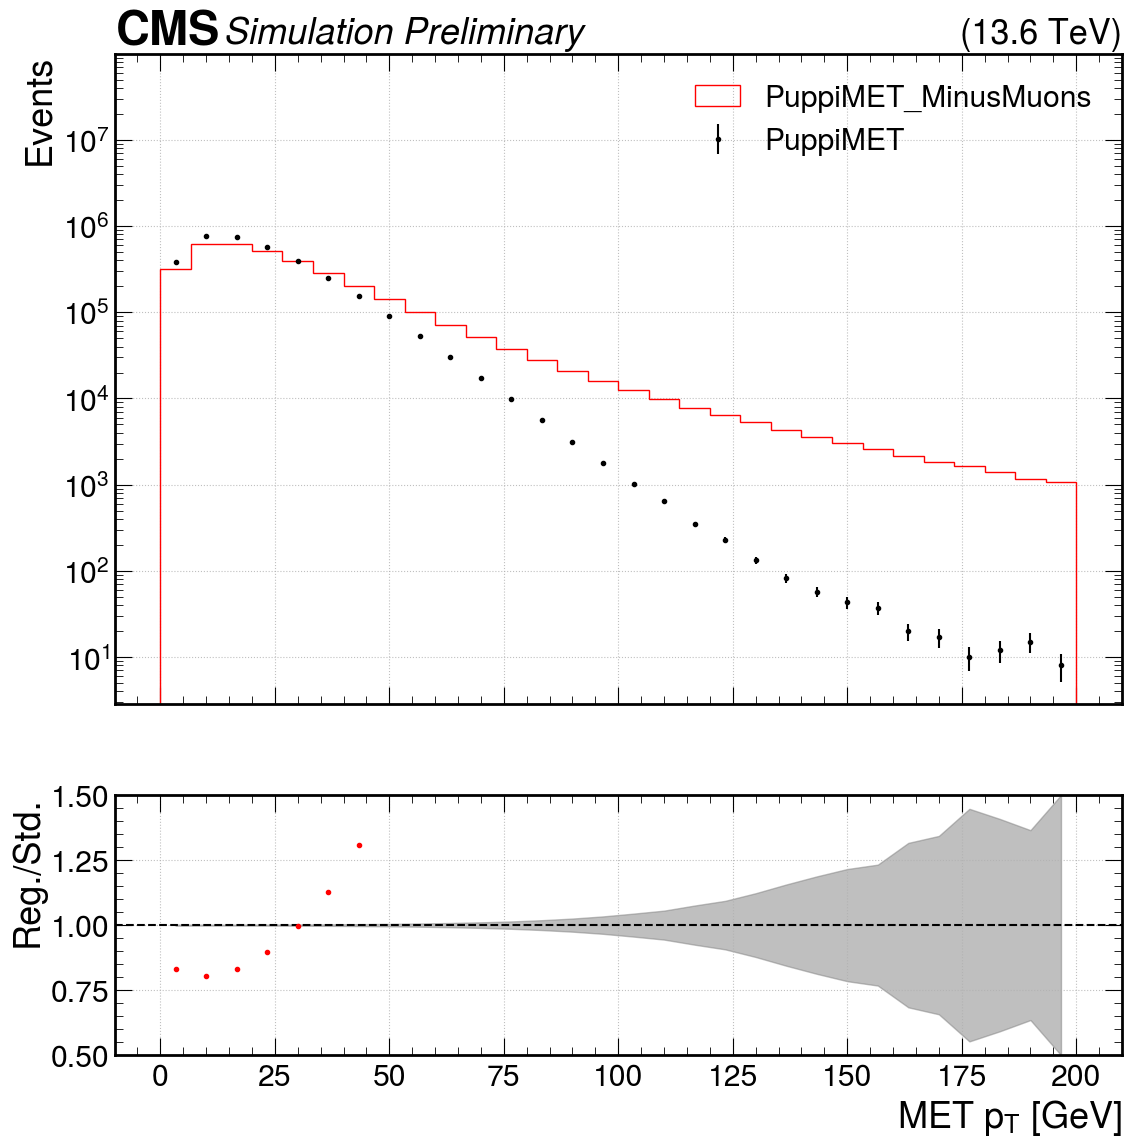

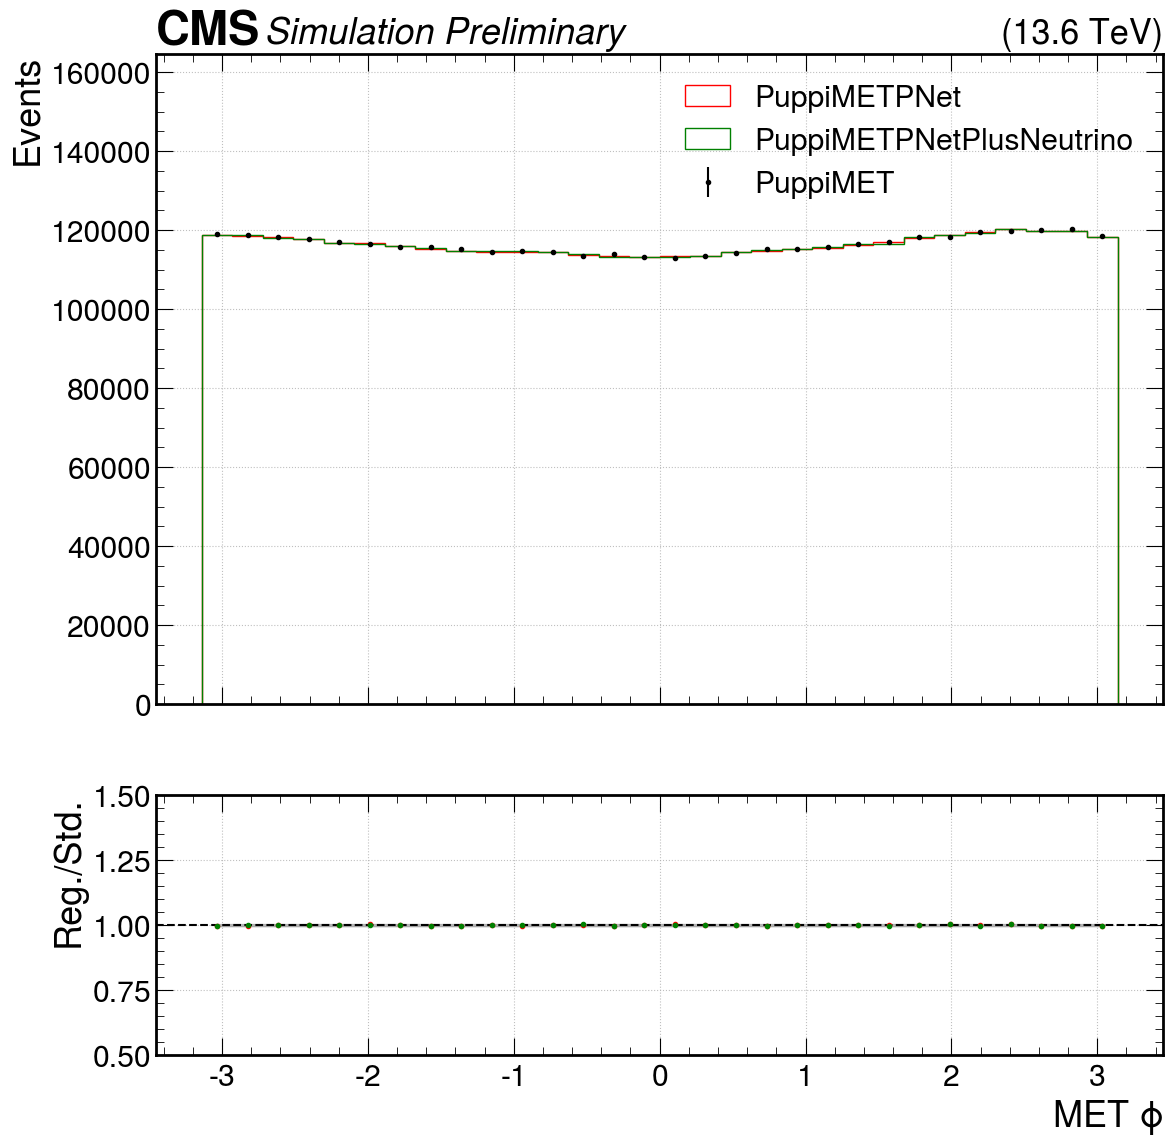

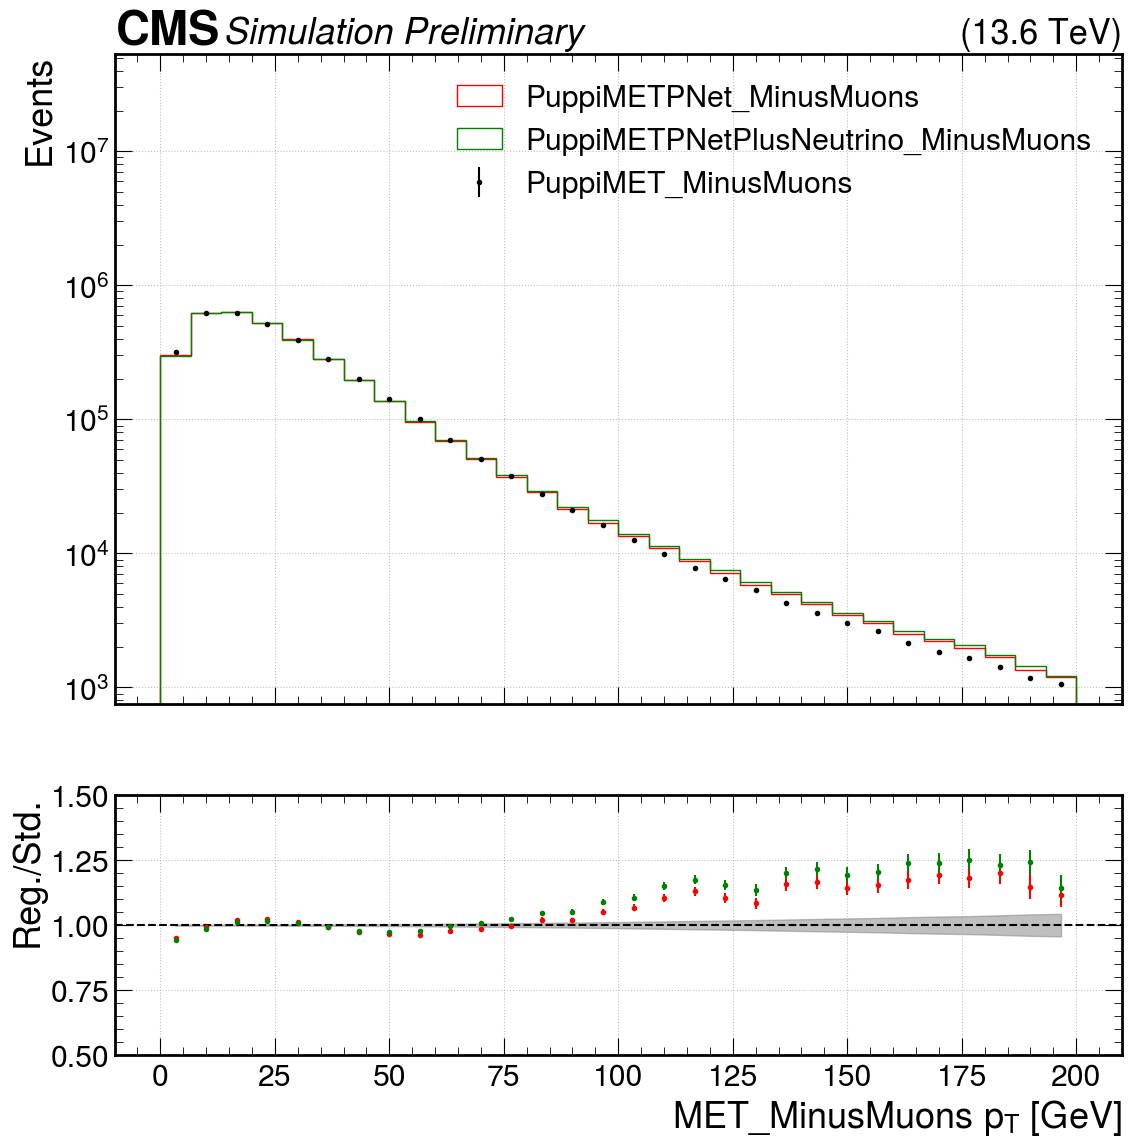

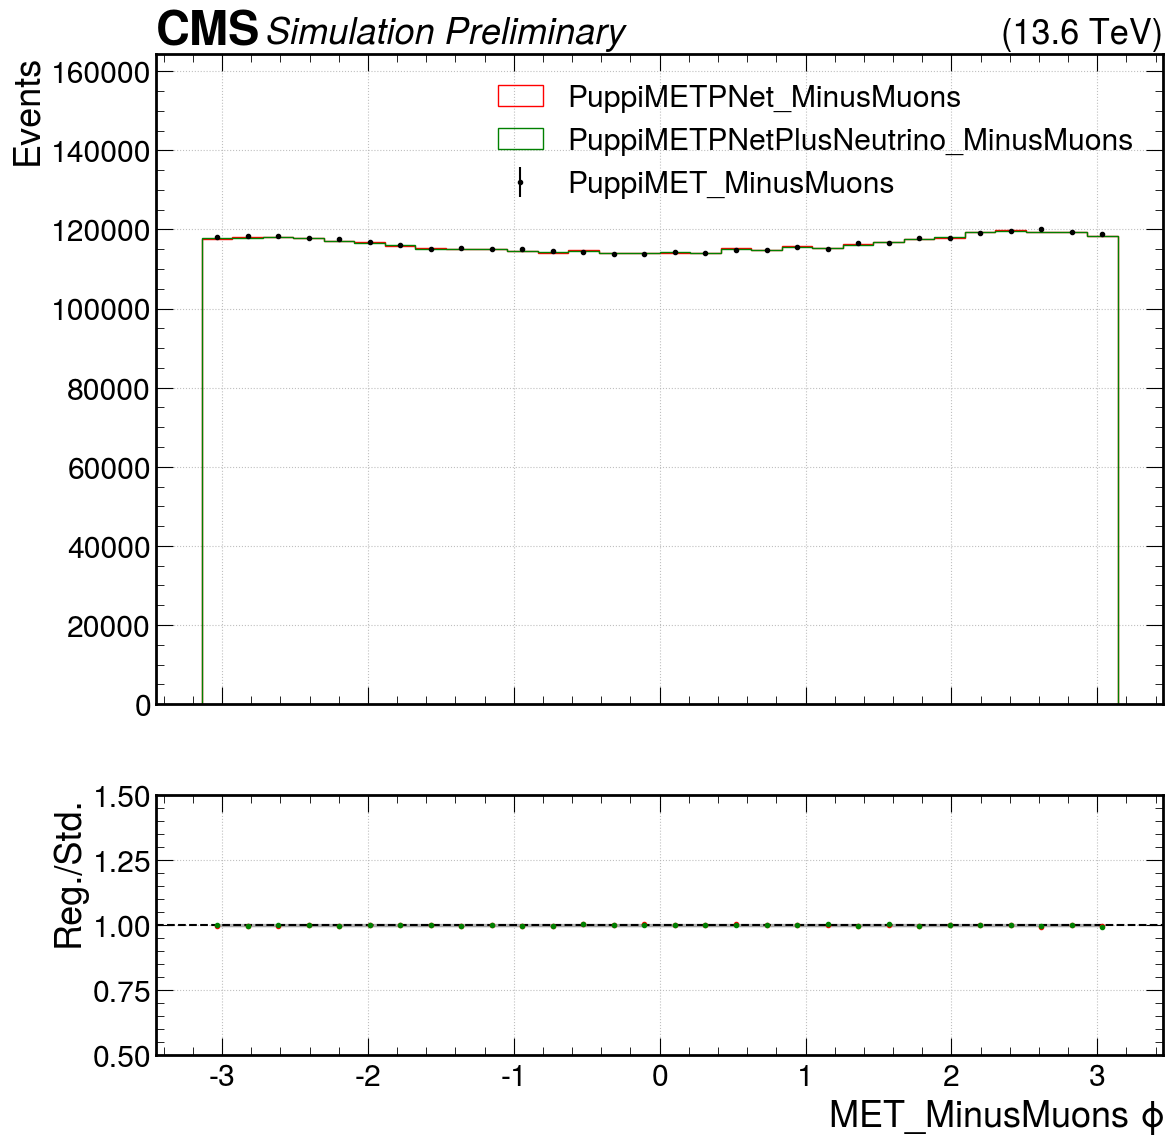

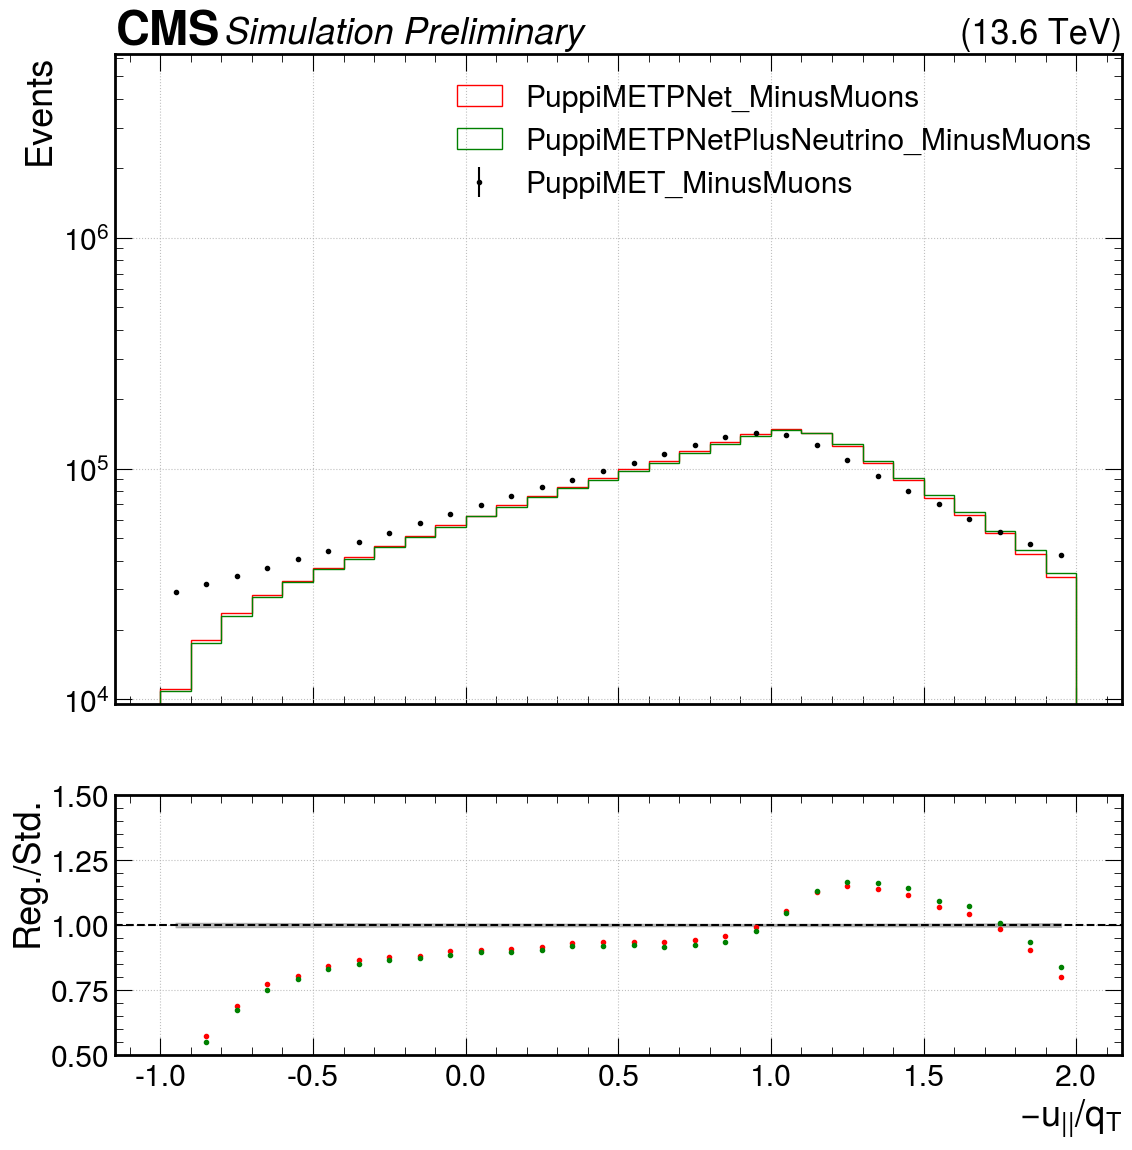

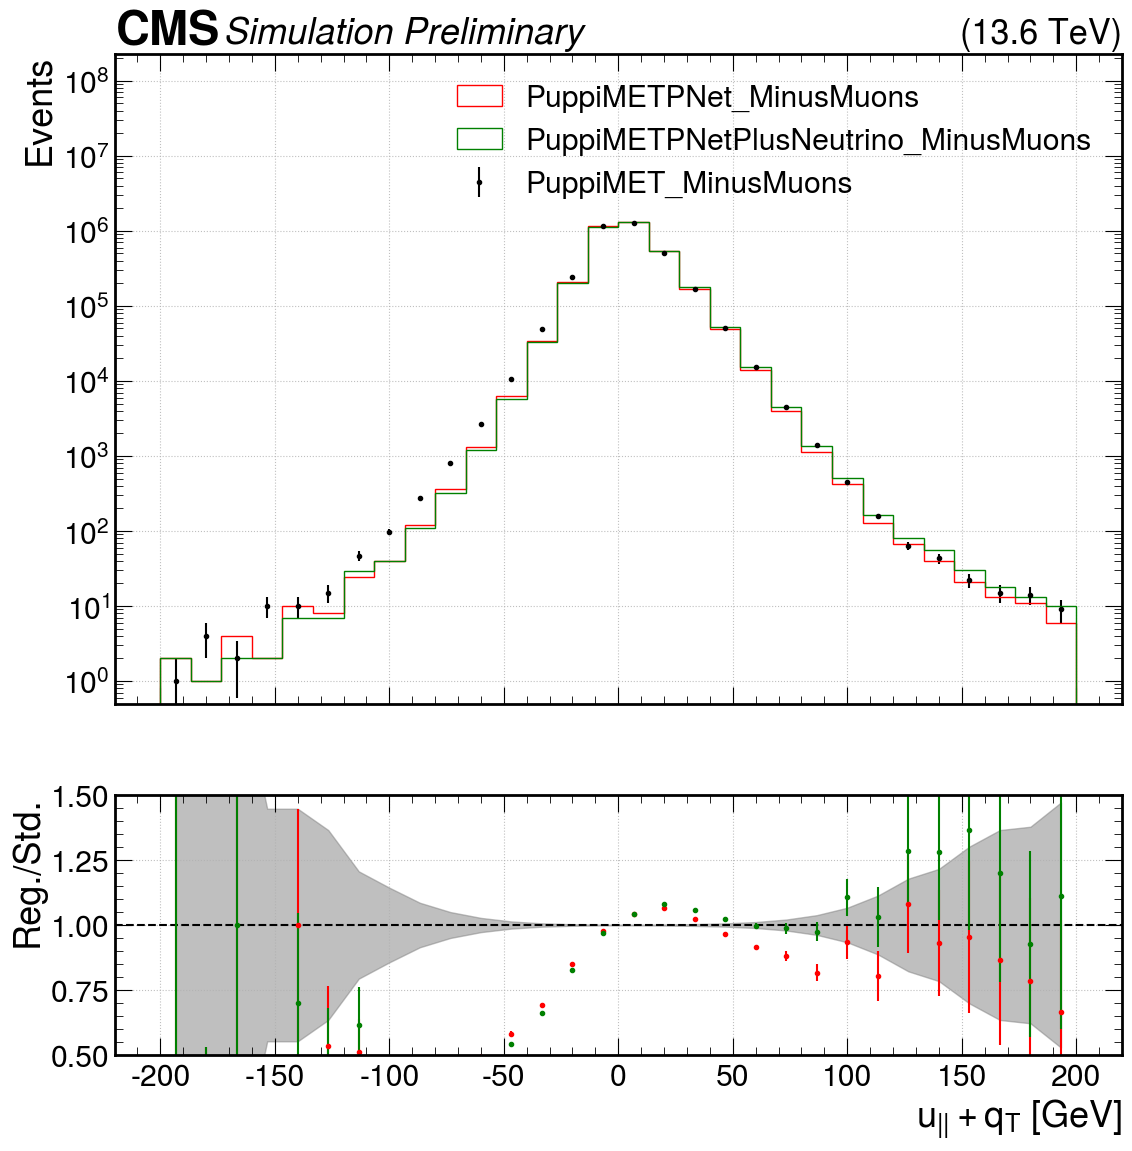

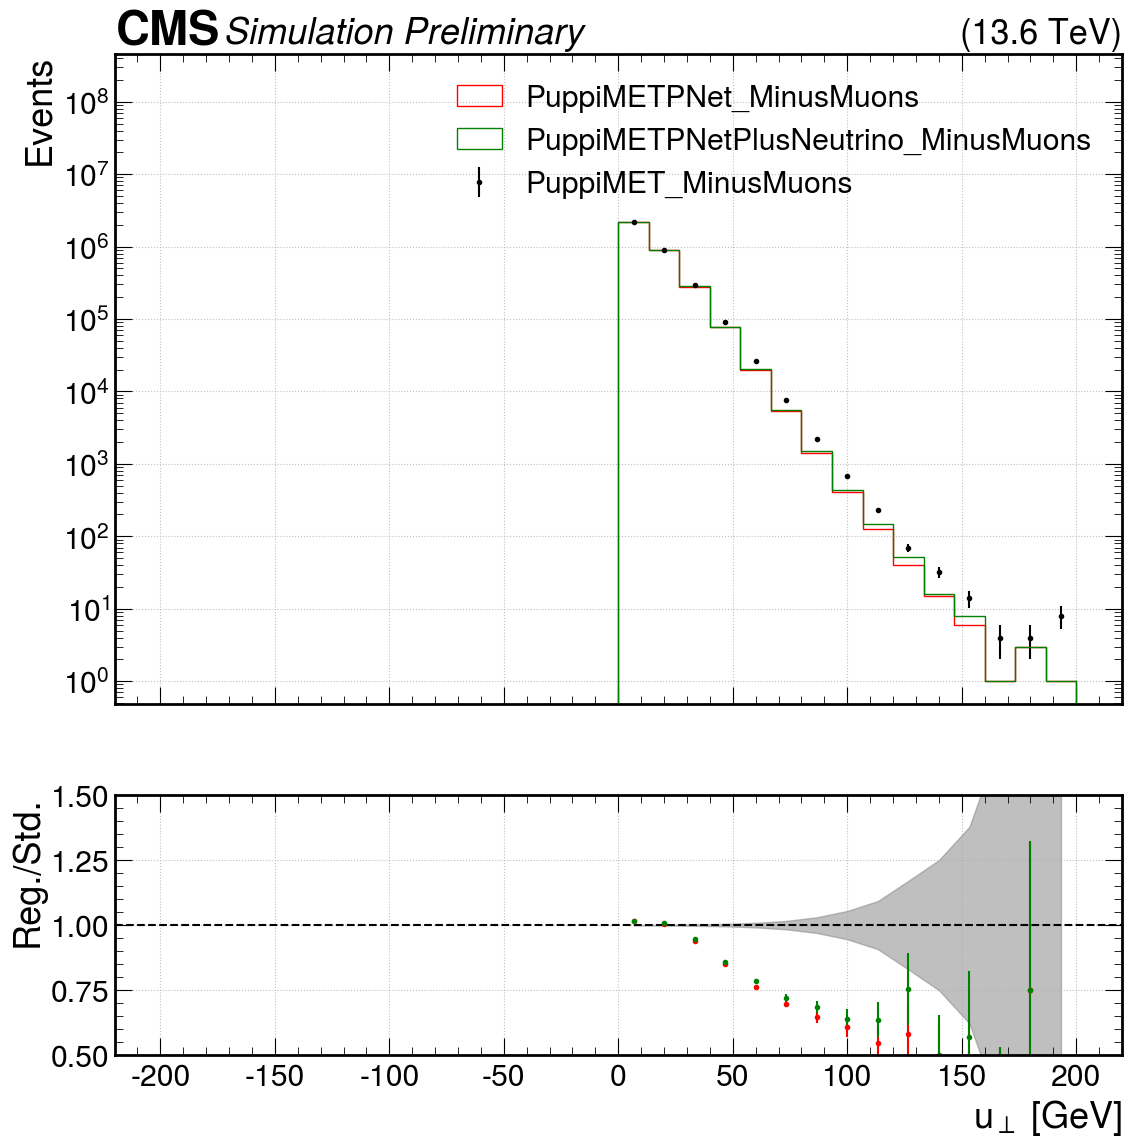

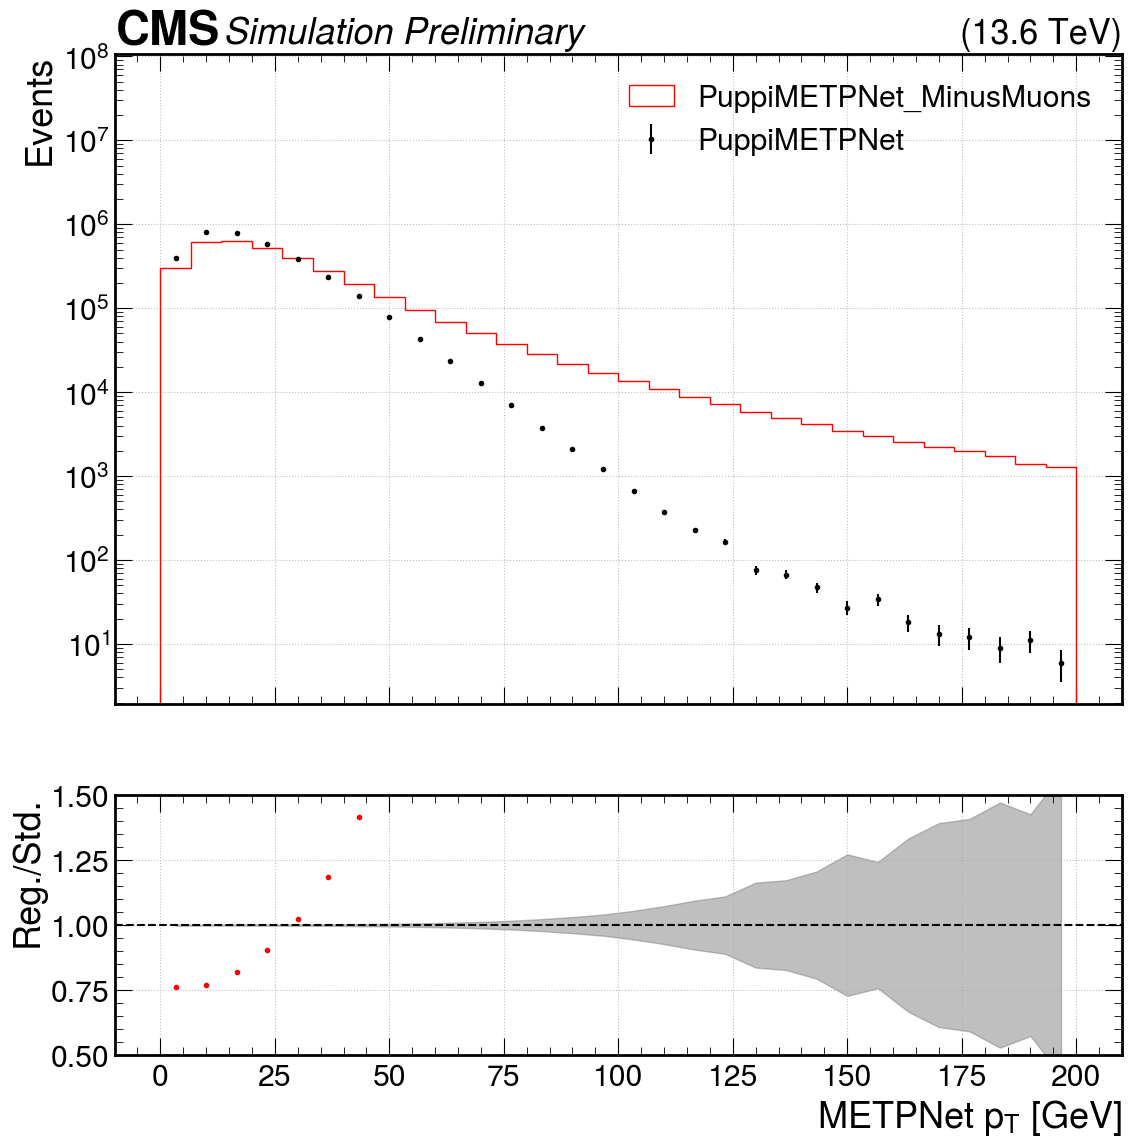

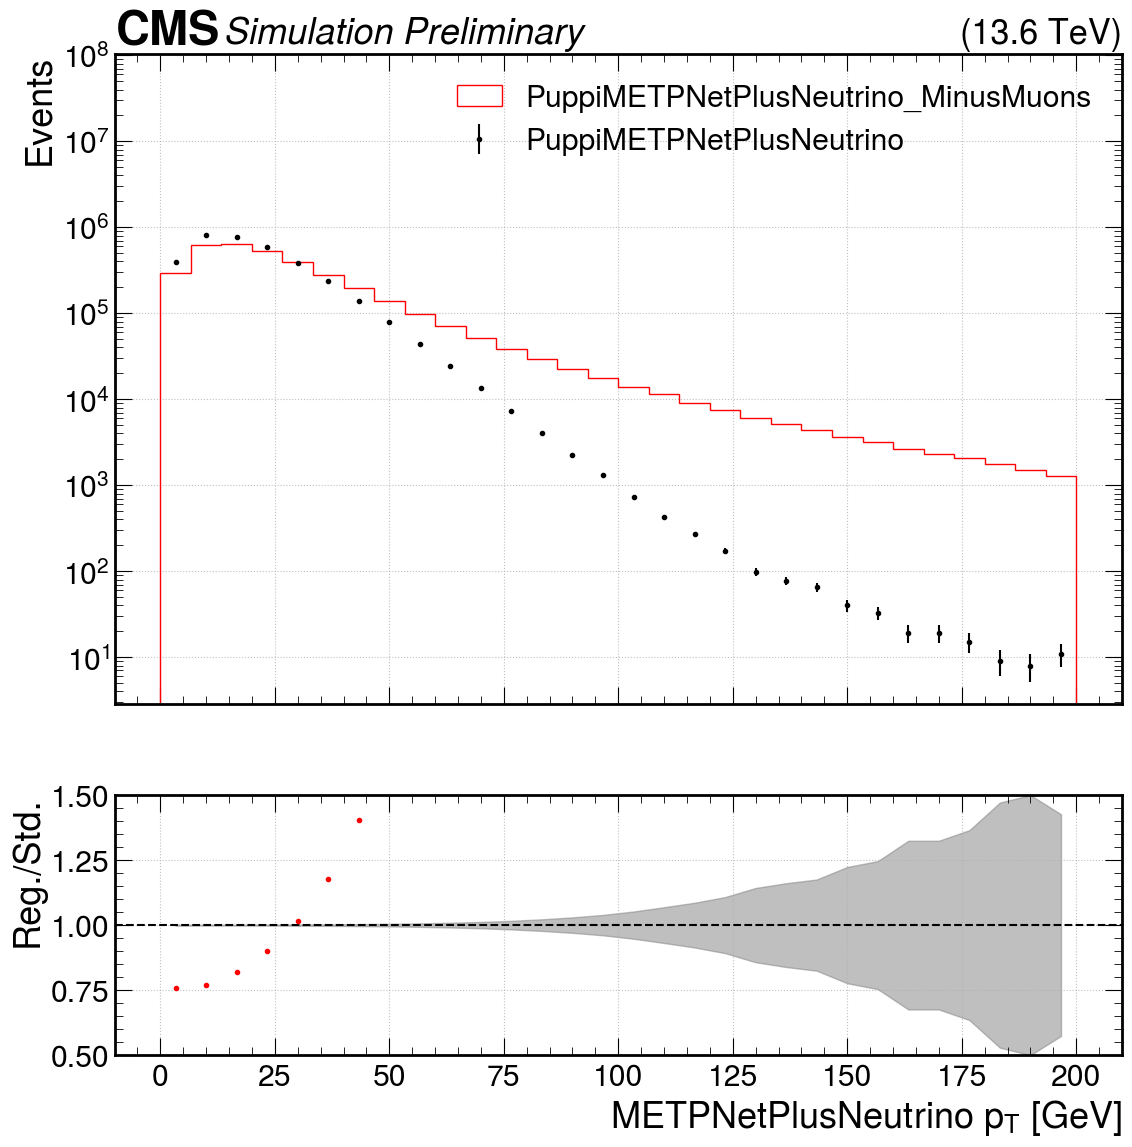

In [16]:
plot_from_columns(accumulator)